In [45]:
import os
import dlib
import cv2
import random
import json
from tqdm import tqdm
from matplotlib import pyplot as plt


In [19]:
raw_images_path = '../dataset/images/raw'
raw_image_filenames = os.listdir(raw_images_path)

train_output_path = '../dataset/images/statues128/train/statue'
train_landmarks_output_path = f'{train_output_path}/statues128landmarks.json'

test_output_path  = '../dataset/images/statues128/test/statue'
test_landmarks_output_path = f'{test_output_path}/statues128landmarks.json'
landmarks_obj = dict()

### Filter images containing faces detected by dlib pretrained face detector

In [33]:
shape_predictor_pretrained_model_path = '../pretrained_models/dlib_68_face_landmarks_predictor.dat'
face_detector_pretrained_model   = dlib.get_frontal_face_detector()
face_images = list()
no_face_images = list()
for img_filename in tqdm(raw_image_filenames):
    train_img_path = f'{raw_images_path}/{img_filename}'
    train_img = cv2.imread(train_img_path)
    
    try:
        faces = face_detector_pretrained_model(train_img)
        if not faces:
            no_face_images.append(img_filename)
        else:
            face_images.append(img_filename)
    except Exception as e:
        no_face_images.append(img_filename)
        print(e)

print('No. of raw images with faces found', len(face_images))
print('No. of raw images with no faces found: ', len(no_face_images))

 51%|█████     | 1120/2194 [00:15<00:17, 60.34it/s]

__call__(): incompatible function arguments. The following argument types are supported:
    1. (self: _dlib_pybind11.fhog_object_detector, image: array, upsample_num_times: int=0) -> _dlib_pybind11.rectangles

Invoked with: <_dlib_pybind11.fhog_object_detector object at 0x137b5e530>, None


100%|██████████| 2194/2194 [00:29<00:00, 74.49it/s]

No. of raw images with faces found 1425
No. of raw images with no faces found:  769


### Separate 128x128 train and test statue dataset

Size of full dataset:  1425
Size of training dataset:  1275
Size of testing dataset:  140
Size of validation dataset:  10

Validation images: istock_0493.jpg; flickr_0584.jpg; flickr_0328.jpg; flickr_0200.jpg; flickr_0102.jpg; flickr_0463.jpg; flickr_0306.jpg; istock_0005.jpg; flickr_0872.jpg; flickr_0537.jpg


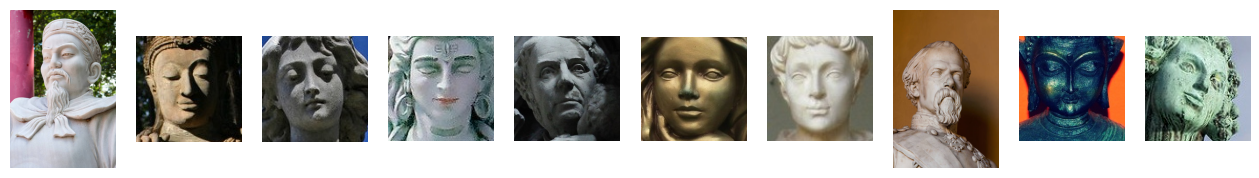

In [80]:
face_images = sorted(face_images)


# shuffle raw images with well defined seed to get same results
random.Random(8).shuffle(face_images)

test_images  = face_images[:140]
train_images = face_images[140:1415]
valid_images = face_images[1415:]

print('Size of full dataset: ',       len(face_images))
print('Size of training dataset: ',   len(train_images))
print('Size of testing dataset: ',    len(test_images))
print('Size of validation dataset: ', len(valid_images))
f = plt.figure(figsize=(16, 7))

print('\nValidation images:' , '; '.join(valid_images))
for i, valid_img_filename in enumerate(valid_images):
    ax = f.add_subplot(1, len(valid_images), i+1)
    ax.set_axis_off()
    plt.imshow(
        cv2.cvtColor(
            cv2.imread(f'{raw_images_path}/{valid_img_filename}'), cv2.COLOR_BGR2RGB
        ),
    )

plt.show()

### Crop faces to 128x128 images

In [85]:
def save_cropped_faces(images, dest):
    statues_cropped_path = dest
    face_detector_pretrained_model   = dlib.get_frontal_face_detector()
    for img_filename in tqdm(images):
        img_path = f'{raw_images_path}/{img_filename}'
        img = cv2.imread(img_path)
        

        img_height, img_width, _ = img.shape
        faces = face_detector_pretrained_model(img)
        for face in faces:
            face_xl = face.left() # left point
            face_yt = face.top() # top point
            face_xr = face.right() # right point
            face_yb = face.bottom() # bottom point
            cropped_face_image = img[max(0, face_yt-40): min(img_height, face_yb+40), max(0, face_xl-40): min(img_width, face_xr+40)]
            cropped_face_128x128 = cv2.resize(cropped_face_image, (128, 128))
            cropped_img_filename = '{0}_cropped.{1}'.format(*img_filename.split('.'))
            cv2.imwrite(f'{statues_cropped_path}/{cropped_img_filename}', cropped_face_128x128)
            


#### Train

In [107]:
train_128_path = '../dataset/images/statues128/train'
train_128img_path = f'{train_128_path}/statue'
test_128_path = '../dataset/images/statues128/test'
test_128img_path =  f'{test_128_path}/statue'
valid_128_path = '../dataset/images/statues128/valid'
valid_128img_path = f'{valid_128_path}/statue'

In [108]:
# Process train images
print('Train: ')
save_cropped_faces(train_images, train_128img_path)

# Process test images
print('Test: ')
save_cropped_faces(test_images, test_128img_path)

# Process valid images
print('Valid: ')
save_cropped_faces(valid_images, valid_128img_path)

Train: 


100%|██████████| 1275/1275 [00:15<00:00, 82.49it/s] 


Test: 


100%|██████████| 140/140 [00:01<00:00, 79.40it/s]


Valid: 


100%|██████████| 10/10 [00:00<00:00, 143.70it/s]


### Load landmarks file to datasets

To generate face landmarks for faces in dataset will generate a file with shape
`````json
{
  "0001.jpg": {
    "00": {"x": 22, "y": 48},
    "01": {"x": 22, "y": 60},
    ...
    "66": {"x": 68, "y": 89},
    "67": {"x": 65, "y": 87},
    "height": 87, "left": 26, "top": 26, "width": 87
  },
  ...
}
`````


In [109]:
def load_landmarks_json_file(images_path, output_path):
    shape_predictor_pretrained_model_path = '../pretrained_models/dlib_68_face_landmarks_predictor.dat'
    face_detector_pretrained_model   = dlib.get_frontal_face_detector()
    shape_predictor_pretrained_model = dlib.shape_predictor(shape_predictor_pretrained_model_path)

    landmarks = {}
    for img128_filename in tqdm(os.listdir(images_path)):
        path = f'{images_path}/{img128_filename}'
        img = cv2.imread(path)
        faces = face_detector_pretrained_model(img)
        if len(faces) == 1:
            face = faces[0]
            prediction = shape_predictor_pretrained_model(img, face)
            face_landmarks = {
                f'{k:02d}': {"x": p.x, "y": p.y}
                for k, p in enumerate(prediction.parts())
            }
            face_landmarks.update({
                "top": face.top(),
                "left": face.left(),
                "width": face.width(),
                "height": face.height()
            })
            landmarks.update({img128_filename: face_landmarks})

    with open(output_path, 'w') as landmarks_output:
        landmarks_output.write(
            json.dumps(landmarks, indent=None, sort_keys=True, )
        )


In [110]:
landmarks_filename = 'statues128landmarks.json'
print(f'Loading train landmarks into {train_128_path}/{landmarks_filename}')
load_landmarks_json_file(train_128img_path, f'{train_128_path}/{landmarks_filename}')

print(f'Loading test landmarks into {test_128_path}/{landmarks_filename}')
load_landmarks_json_file(test_128img_path, f'{test_128_path}/{landmarks_filename}')

print(f'Loading valid landmarks into {valid_128_path}/{landmarks_filename}')
load_landmarks_json_file(valid_128img_path, f'{valid_128_path}/{landmarks_filename}')


Loading train landmarks into ../dataset/images/statues128/train/statues128landmarks.json


100%|██████████| 1275/1275 [00:04<00:00, 274.19it/s]


Loading test landmarks into ../dataset/images/statues128/test/statues128landmarks.json


100%|██████████| 140/140 [00:00<00:00, 276.08it/s]


Loading valid landmarks into ../dataset/images/statues128/valid/statues128landmarks.json


100%|██████████| 10/10 [00:00<00:00, 234.49it/s]
